### Imports
The *gym_anytrading* import is needed to create a gymnasium environment.

In [45]:
import utils
import crypto_env

import gym_anytrading
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs

from stable_baselines3 import A2C, PPO

### Defining the DataFrame

In [46]:
dataset_path = "data/crypto/btc-usd.csv"
dataset_type = "crypto-v0"  # "stocks-v0", "forex-v0", "crypto-v0"

df = pd.read_csv(
    dataset_path,
    header=0,
    parse_dates=["Date"],
    index_col="Date",
)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


### Creating the environment

In [47]:
seed = 69  # Nice

total_num_episodes = 50
total_learning_timesteps = 1_000_000

window_size = 15
end_index = len(df)

env = gym.make(
    dataset_type,
    df=df,
    window_size=window_size,
    frame_bound=(window_size, end_index),
)

# Matplotlib
plot_settings = {}
plot_data = {"x": [i for i in range(1, total_num_episodes + 1)]}

### Training and testing the model

1. With Advantage Actor-Critic algorithm
2. With Proximal Policy Optimization algorithm
3. With random actions

In [48]:
def train_and_get_rewards(model_name):
    print(f"Training {model_name} model…")

    if model_name == "A2C":
        model = A2C("MlpPolicy", env)
    elif model_name == "PPO":
        model = PPO("MlpPolicy", env)
    else:
        model = None

    rewards, info = utils.train_test_model(model, env, seed, total_learning_timesteps, total_num_episodes)
    _, _, avg_res = utils.get_results(rewards, model_name, print_results=True)
    
    if model_name != "random":
        print(f"Total_Profit = {info[0]['total_profit']}")
    plot_data[f"{model_name}_rewards"] = rewards
    plot_settings[f"{model_name}_rewards"] = {"label": model_name}


train_and_get_rewards("random")
train_and_get_rewards("PPO")
train_and_get_rewards("A2C")

Training random model…


Episode: 40, Avg. Reward: 26908.468: 100%|██████████| 50/50 [00:02<00:00, 23.04it/s]



Results for random model:
Minimum reward: 26908.468
Maximum reward: 26908.468
Average reward: 26908.468

Training PPO model…


model.learn(): 1001400it [18:31, 900.80it/s]                             
Episode: 40, Avg. Reward: 71896.031: 100%|██████████| 50/50 [01:29<00:00,  1.79s/it]



Results for PPO model:
Minimum reward: 33569.027
Maximum reward: 114740.852
Average reward: 69027.680

Total_Profit = 80.29775151867847
Training A2C model…


Episode: 40, Avg. Reward: 0.000: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


Results for A2C model:
Minimum reward: 0.000
Maximum reward: 0.000
Average reward: 0.000

Total_Profit = 0.0037840928470638906


### Plotting the results

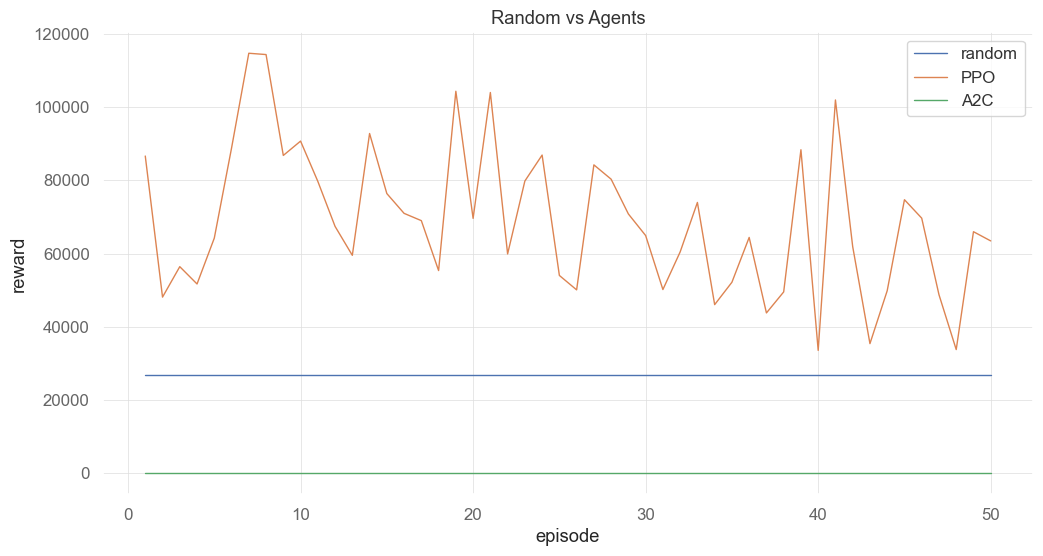

In [49]:
data = pd.DataFrame(plot_data)
plt.figure(figsize=(12, 6))
for key in plot_data:
    if key == "x":
        continue
    line = plt.plot("x", key, data=data, linewidth=1, label=plot_settings[key]["label"])


plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Random vs Agents")
plt.legend()
plt.show()